##**PROJET  : Recommandation d’artistes en utilisant le filtrage collaboratif**

**Realisé par :** Arij BOUGDA & Khalil LAZHARI & Amal SAIDI & Chayma BELGAIED 




###**Business understanding:**

Le but de ce projet est de développer plusieurs méthodes de recommandation d’artistes basées 
sur le filtrage collaboratif (collaborative filtering).

### **Data understanding:**

This dataset contains social networking, tagging, and music artist listening information  from a set of 2K users from Last.fm online music system.
http://www.last.fm



**The Dataset:** 

Six .csv files are provided in this dataset consisting of the following:

*   **artists.dat** (id, name, url, pictureURL). ID and name of each artist.
*   **tags.dat** (tagID, tagValue). ID number and content for each tag.
*   **user_artists.dat** (userID, artistID, weight). Plays of artist by user.
*   **user_friends.dat** (userID, friendID). User/friend relationships.
*   **user_taggedartists.dat** (userID, artistID, tagID, day, month, year). Tag of artist by user with date.
*   **user_taggedartists-timestamps.dat** (userID, artistID, tagID, timestamp). Tag of artist by user with timestamp.

**Import packages**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import maxabs_scale, minmax_scale
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
import string
import re
import math
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.metrics import mean_squared_error

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.3)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

**import our files**

In [ ]:
#user_artists
!wget https://www.dropbox.com/s/rzlveshptoi2qsv/user_artists.csv
#artists
!wget https://www.dropbox.com/s/y4u29xfg9byctwf/artists.csv
#tags
!wget https://www.dropbox.com/s/9vmgtyv03el8rvw/tags.csv
#user_friends
!wget https://www.dropbox.com/s/kwdccj70vaq7c9i/user_friends.csv
#user_taggedartists
!wget https://www.dropbox.com/s/lvxnk18ow3btalv/user_taggedartists.csv
#user_taggedartists-timestamps
!wget https://www.dropbox.com/s/vzlydh3bvb32hhl/user_taggedartists-timestamps.csv

In [ ]:
# import our files
user_artists = pd.read_csv('user_artists.csv')
artists = pd.read_csv('artists.csv')
tags = pd.read_csv('tags.csv')
user_tagart = pd.read_csv('user_taggedartists.csv')
user_tagarts = pd.read_csv('user_taggedartists-timestamps.csv')
user_friends = pd.read_csv('user_friends.csv')

In [ ]:
# create a function to provide various statistics on our data files
def print_info(df_list, df_name):
    
    # assertion to ensure our two lists are equal in length (ie we didn't make any mistakes)
    assert len(df_list) == len(df_name)

    for i in range(len(df_list)):
        print(df_name[i],'\n')
        print("Shape: {}\n".format(df_list[i].shape))
        print("Info:")
        print(df_list[i].info(),'\n')
        print("Unique:\n{}\n".format(df_list[i].nunique()))     
        
        # This returns True if no duplicates are dropped (ie duplicates do not exist)
        print("No duplicates: {}\n".format(len(df_list[i])==len(df_list[i].drop_duplicates())))

In [ ]:
df_list = [user_artists, artists, tags, user_tagart, user_tagarts, user_friends]
df_name = ['**user artists**',
           '**Artists**',
           '**Tags**',
           '**User Tagged Artists (Date)**',
           '**User Tagged Artists (Timestamp)**',
           '**Friends**']

print_info(df_list,df_name)

**user artists** 

Shape: (92834, 3)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    92834 non-null  int64
 1   artistID  92834 non-null  int64
 2   weight    92834 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB
None 

Unique:
userID       1892
artistID    17632
weight       5436
dtype: int64

No duplicates: True

**Artists** 

Shape: (17632, 4)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17632 non-null  int64 
 1   name        17632 non-null  object
 2   url         17632 non-null  object
 3   pictureURL  17188 non-null  object
dtypes: int64(1), object(3)
memory usage: 551.1+ KB
None 

Unique:
id            17632
name          17632
url           17632
picture

###**Data preparation:**

In [ ]:
#User-Artist Matrix
x=np.zeros((1892,17632))
matrix=pd.DataFrame(x,index=user_artists["userID"].unique(),columns=user_artists["artistID"].unique())
for i in range(user_artists.shape[0]):
    matrix.loc[user_artists.iloc[i][0], user_artists.iloc[i][1]]=user_artists.iloc[i][2]

In [ ]:
# User-Item Normalized 0,1 Matrix
z=np.zeros((1892,17632))
matrix2=pd.DataFrame(z,index=user_artists["userID"].unique(),columns=user_artists["artistID"].unique())
for i in range(user_artists.shape[0]):
    matrix2.loc[user_artists.iloc[i][0], user_artists.iloc[i][1]]=user_artists.iloc[i][2]

binary_user_item = matrix2

binary_user_item[binary_user_item != 0] = 1


In [ ]:
#TagMatrix
m1=user_tagarts["artistID"]
m2=user_artists["artistID"]
artistcorr=pd.concat([m1,m2]).unique()
y=np.zeros((1892,18022))
tagtrix=pd.DataFrame(y,index=user_tagarts["userID"].unique(),columns=artistcorr)
for i in range(user_tagarts.shape[0]):
    tagtrix.loc[user_tagarts.iloc[i][0], user_tagarts.iloc[i][1]] += 1
tagtrix = tagtrix[tagtrix.columns.intersection(user_artists["artistID"].unique())]


# User-Item Normalized 0,1 Matrix
z=np.zeros((1892,17632))
matrix2=pd.DataFrame(z,index=user_artists["userID"].unique(),columns=user_artists["artistID"].unique())
for i in range(user_artists.shape[0]):
    matrix2.loc[user_artists.iloc[i][0], user_artists.iloc[i][1]]=user_artists.iloc[i][2]



binary_user_item = matrix2

binary_user_item[binary_user_item != 0] = 1


# User-Item Normalized 0..5 Matrix


#maxabs_scale = x/abs(xmax)
matrix_scale = maxabs_scale(matrix[matrix != 0], axis=1)
tagtrix_scale = maxabs_scale(tagtrix[tagtrix != 0], axis=1)




df1=pd.DataFrame(matrix_scale,index=user_artists["userID"].unique(),columns=user_artists["artistID"].unique())
df2=pd.DataFrame(tagtrix_scale,index=user_artists["userID"].unique(),columns=user_artists["artistID"].unique())


df1[df1 == 0].count().sum() # No zero
df2[df2 == 0].count().sum() # No zero
# Il n'y a aucune valeur nulle donc on peut remplacer les NaN par des 0 pour faciliter l'addition

df1=df1.fillna(0)
df2=df2.fillna(0)


# On optimise les ratings grâce à la normalisation des colonnes, minmax scaler = (x - xmin)/(xmax - xmin)
dff1=(df1.sum()+1)/(df1[df1 == 0].count()+1)
fd1 = maxabs_scale(dff1, axis=0)
fdd = df1[df1 != 0] + fd1
fdd[289].mean()
fdd.mean().mean()
fdd.mean().max()
fdd.mean().std()


dff2=(df2.sum()+1)/(df2[df2 == 0].count()+1)
fd2 = maxabs_scale(dff2, axis=0)
fdg = df2[df2 != 0] + fd2
fdg[289].mean()
fdg.mean().mean()
fdg.mean().max()
fdg.mean().std()


# Le rating finale s'obtient en moyennant les tags et les écoutes
user_item = (fdd.fillna(0)*2 + fdg.fillna(0))
user_item = (user_item/user_item[user_item != 0].max().max())*5

user_item=user_item[user_item != 0]




user_item[user_item != 0].mean().max()
user_item[user_item != 0].mean().std()
user_item[user_item != 0].mean().mean()
user_item[user_item != 0].max().max()





matrix=matrix[matrix != 0]
#tagtrix=tagtrix[tagtrix != 0]

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:976: RuntimeWarning: All-NaN slice encountered
  max_abs = np.nanmax(np.abs(X), axis=0)


In [ ]:

ap = pd.merge(
  artists, user_artists, 
  how="inner",
  left_on="id",
  right_on="artistID"
)
ap = ap.rename(columns={"weight": "playCount"})
artist_rank = ap.groupby(['name']) \
  .agg({'userID' : 'count', 'playCount' : 'sum'}) \
  .rename(columns={"userID" : 'totalUniqueUsers', "playCount" : "totalArtistPlays"}) \
  .sort_values(['totalArtistPlays'], ascending=False)

artist_rank['avgUserPlays'] = artist_rank['totalArtistPlays'] / artist_rank['totalUniqueUsers']
ap = ap.join(artist_rank, on="name", how="inner") \
  .sort_values(['playCount'], ascending=False)
pc = ap.playCount
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())

ap = ap.assign(playCountScaled=play_count_scaled)
ratings_df = ap.pivot(
    index='userID', 
    columns='artistID', 
    values='playCountScaled'
)
ratings = ratings_df.fillna(0).values

 **Data visualization** 

['Britney Sp', 'Lady Gaga', 'The Beatle', 'Phillip Bo', 'Hamza El D']


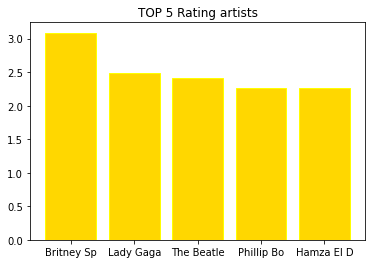

In [ ]:
#1st plot: Top 5 Rating Artists
bestratingsmean = user_item.mean().sort_values(ascending=False).head(5)
names = []
for r in bestratingsmean.index:
    names.append(artists[artists['id']==r].name.values[0][:10])
print(names)

plt.bar(np.arange(5), bestratingsmean.values, color="gold", edgecolor="yellow")
plt.title("TOP 5 Rating artists")
plt.xticks(np.arange(5), names)
plt.show()


['Britney Sp', 'Depeche Mo', 'Lady Gaga', 'Christina ', 'Paramore']


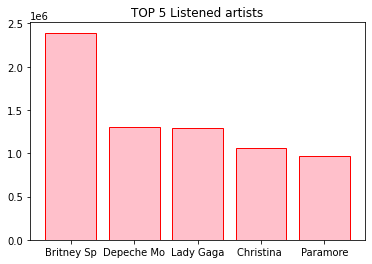

In [ ]:
#2nd plot: Top 5 Listened Artists

bestlistened = matrix.sum().sort_values(ascending=False).head(5)
names = []
for r in bestlistened.index:
    names.append(artists[artists['id']==r].name.values[0][:10])
print(names)

plt.bar(np.arange(5),bestlistened, color="pink", edgecolor="red")
plt.title("TOP 5 Listened artists")
plt.xticks(np.arange(5),names)
plt.show()

['Britney Sp', 'Lady Gaga', 'Christina ', 'Madonna', 'Depeche Mo']


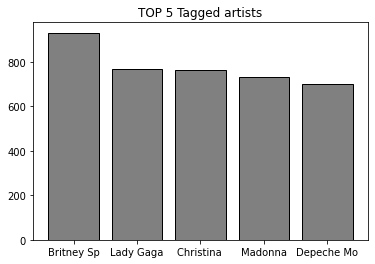

In [ ]:
#3rd plot: Top 5 Tagged artists
besttagged = tagtrix.sum().sort_values(ascending=False).head(5)
names = []
for r in besttagged.index:
    names.append(artists[artists['id']==r].name.values[0][:10])
print(names)

plt.bar(np.arange(5),besttagged, color="grey", edgecolor="black")
plt.title("TOP 5 Tagged artists")
plt.xticks(np.arange(5),names)
plt.show()

['Lady Gaga', 'Britney Sp', 'Rihanna', 'The Beatle', 'Katy Perry']


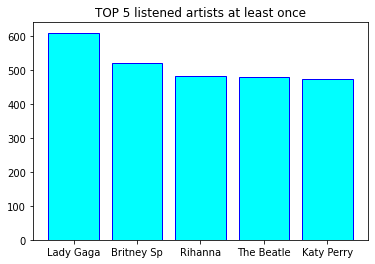

In [ ]:
#4th plot: Top 5 Listened at least once 
bestonce = binary_user_item.sum().sort_values(ascending=False).head(5)
names = []
for r in bestonce.index:
    names.append(artists[artists['id']==r].name.values[0][:10])
print(names)

plt.bar(np.arange(5),bestonce, color="cyan", edgecolor="blue")
plt.title("TOP 5 listened artists at least once")
plt.xticks(np.arange(5),names)
plt.show()

In [ ]:
# Stats
matrix.mean().describe()
user_item.mean().describe()
binary_user_item.mean().describe()

count    17632.000000
mean         0.002783
std          0.010899
min          0.000529
25%          0.000529
50%          0.000529
75%          0.001586
max          0.322939
dtype: float64

### **Modeling**

####**User-based method**

 By specifying the metric = cosine, the model will measure similarity bectween users by using cosine similarity

In [ ]:
#Similarity
uis=cosine_similarity(user_item.fillna(0)[user_item != 0])
user_item_similarity=pd.DataFrame(uis,index=user_artists["userID"].unique(),columns=user_artists["userID"].unique())

uibs=cosine_similarity(binary_user_item)
user_item_binary_similarity=pd.DataFrame(uibs,index=user_artists["userID"].unique(),columns=user_artists["userID"].unique())
    

In [ ]:
#Top 10 Nearest neighbors matrix

user_item_similarity.loc[2].sort_values(ascending=False).index[:10]

#Top n Nearest neighbors matrix
#Par défaut k=0
def topn_neighbors(dd,k,n):
    v=np.zeros((1892,n-k))
    sort = ["top %d"%(i+1) for i in range(k,n)]
    ddd=pd.DataFrame(v,index=user_artists["userID"].unique(),columns=sort).astype('int')
    for user in dd.index:
# On commence par le 2eme indice parce que le premier voisin d'un utilisateur est lui-même.
        nearest = dd.loc[user].sort_values(ascending=False).index[k+1:n+1]
        ddd.loc[user] = nearest
    return ddd

In [ ]:
topn_neighbors(user_item_similarity,0,10).loc[2]
#topn_neighbors(user_item_binary_similarity,10) 

top 1      428
top 2     1866
top 3      374
top 4      761
top 5      243
top 6      193
top 7     1514
top 8      959
top 9      430
top 10    1942
Name: 2, dtype: int64

**Making Recommendations**


 we’re finally ready to make some recommendations!

In [ ]:
#Prediction Matrix 1
from math import isnan
user_item.iloc[2][user_item.loc[2].isna()].index


stuff1=[user_item,user_item_similarity]
stuff2=[binary_user_item,user_item_binary_similarity]


#Fonction de prédiction avec la liste de voisins à paramétrer     
def predict_artist_user(u,user,artist,k,n,l):
    s1=0  
    s2=0
    for s in l:
        if isnan(u[0].loc[s,artist]):
            continue
        else:
            s1 += u[1].loc[user,s] * u[0].loc[s,artist]
            s2 += u[1].loc[user,s]
    if s2==0:
        return(predict_user_artist(u,user,artist,n,2*n))

    return (s1/s2,n)
# Dans le cas où tous les voisins sont nan une récursivité de niveau 1 va se faire en augmentant de 1 voisin pour ne pas tomber dans une boucle infinie
#    if s2==0:  
#        for s in l: 
#            nn = 0
#            nn += predict_user_artist(u,s,artist,n+1)
#            s1 += u[1].loc[user,s] * nn
#            s2 += u[1].loc[user,s]  
                        
# La récursivité prend beauuuuuuucoup de temps dagdguetli ram puisque la plupart des values sont nan donc il est préférable de doubler du même user à chaque fois           


#predict_artist_user(stuff1,2,289,0,10)

stuff1[0].loc[2,289]


#Fonction de prédiction avec la liste des voisins paramétrée
def predict_user_artist(u,user,artist,k,n):
    l=topn_neighbors(u[1],k,n).loc[user]
    return predict_artist_user(u,user,artist,k,n,l)


#Top 5 Recommended artists      
def top_5_artists(u,user,n):
    recommand = u[0].loc[user][u[0].loc[user].isna()].index[:10]
    e = np.zeros((recommand.shape[0]))
    d = pd.Series(e,index=recommand)

    for artist in recommand: #dataseries
        d.loc[artist] = predict_user_artist(u,user,artist,0,n)[0]

    rating = d.sort_values(ascending=False).head(5).values
    stars = d.sort_values(ascending=False).index[:5]
    names = []
    for r in stars:
        names.append(artists[artists['id']==r].name.values[0][:10])
    print("best recommand for user %d"%user)
    return pd.Series(rating,index=names)

###############################################################################


# m : Nombre d'acteurs à sélectionner
# n : Nombre d'users voisins
def top_5(u,user,m,n):
     V=topn_neighbors(u[1],0,n).loc[user]             
     potential=u[0].loc[V.values].mean().sort_values(ascending=False).head(m).index
     Dn=pd.Series(np.zeros(m), index = potential)
     for p in potential :
         Dn.loc[p]=predict_artist_user(u,user,p,0,n,V)[0]  
     rating = Dn.sort_values(ascending=False).head(5).values
     names = []
     stars = Dn.sort_values(ascending=False).index[:5].values
     for r in stars:
        names.append(artists[artists['id']==r].name.values[0][:10])
     print("best recommand for user %d"%user)
     return pd.Series(rating,index=names)




top_5_artists(stuff1,10,30)
top_5(stuff1,2,20,20)

user_item.index


best recommand for user 10
best recommand for user 2


Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2099, 2100],
           dtype='int64', length=1892)

####**clustering model:**

To clustering the data, first of all we need to find the optimal number of clusters. For this purpose, we will define an object for elbow method which will contain two functions first for running k-means algorithm for different number of clusters and other to showing plot.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
import pickle
import sys
from sys import exc_info
import ast

In [ ]:
class elbowMethod():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.differences = list()
    def run(self, init, upto, max_iterations = 300):
        for i in range(init, upto + 1):
            kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
            kmeans.fit(sparseMatrix)
            self.wcss.append(kmeans.inertia_)
        self.differences = list()
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])
    def showPlot(self, boundary = 500, upto_cluster = None):
        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title('Elbow Method Graph')
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(b = True)
        plt.subplot(122).set_title('Differences in Each Two Consective Clusters')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(X_differences, DIFF)
        plt.plot(X_differences, np.ones(len_differences)*boundary, 'r')
        plt.plot(X_differences, np.ones(len_differences)*(-boundary), 'r')
        plt.grid()
        plt.show()

In [ ]:
sparseMatrix=matrix2
elbow_method = elbowMethod(sparseMatrix)  # creation of instance

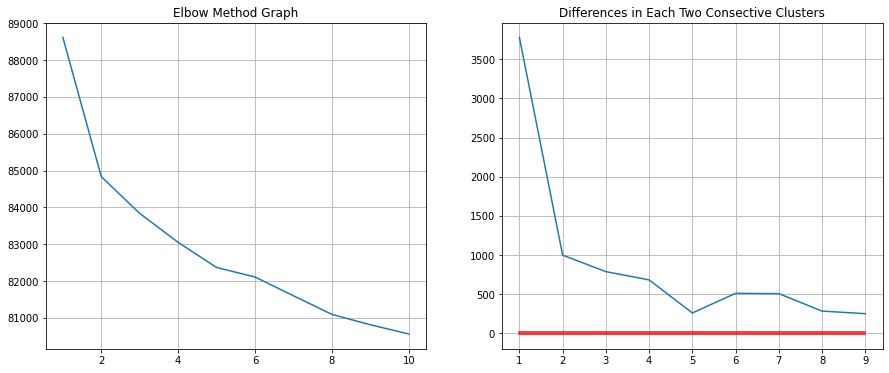

In [ ]:
elbow_method.run(1, 10)
elbow_method.showPlot(boundary = 10)

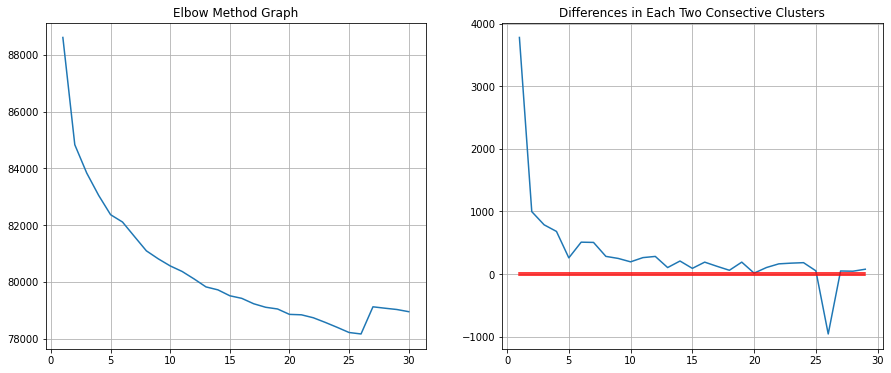

In [ ]:
elbow_method.run(11, 30)
elbow_method.showPlot(boundary = 10)

the optimal k for this case is 26 thanks to the second graph above

**Fitting Data on Model**

In [ ]:
kmeans = KMeans(n_clusters=26, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(sparseMatrix)

In [ ]:
type(clusters)

Now, let create a dataframe where we can see each user cluster number

In [ ]:
users_cluster = pd.DataFrame(np.concatenate((user_artists['userID'].unique().reshape(-1,1), clusters.reshape(-1,1)), axis = 1), columns = ['userID', 'Cluster'])
users_cluster.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891
userID,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,2055,2056,2057,2058,2059,2060,2061,2062,2064,2065,2066,2067,2068,2069,2070,2071,2072,2075,2076,2077,2078,2079,2080,2081,2083,2084,2085,2086,2087,2088,2090,2091,2092,2093,2094,2095,2096,2097,2099,2100
Cluster,17,19,17,4,18,0,8,19,4,13,3,16,19,15,3,13,24,14,16,22,7,5,0,21,19,17,13,13,17,15,1,15,19,23,7,11,19,6,21,4,...,6,6,9,5,16,1,0,4,9,13,6,19,3,9,9,0,11,17,11,20,19,11,17,4,24,2,19,10,16,18,7,12,2,20,11,19,15,2,14,19


Now we’ll define a function which will create a list of DataFrames where each DataFrame will contain the artistId and the counts for that artist (count: the number of users who has that respective artist in their favorite list). So, the artist which will have more counts will be of more interest to other users who has not watched that movie yet. For Example, we’ll create a list as following [dataframe_for_Cluster_1, dataframe_for_Cluster_2, ..., dataframe_for_Cluster_3]

In [ ]:
def clustersArtists(users_cluster, users_data):
    clusters = list(users_cluster['Cluster'])
    each_cluster_artist = list()
    for i in range(len(np.unique(clusters))):
        users_list = list(users_cluster[users_cluster['Cluster'] == i]['userID'])
        users_artists_list = list()
        for user in users_list:    
            users_artists_list.extend(list(users_data[users_data['userID'] == user]['artistID']))
        users_artists_counts = list()
        users_artists_counts.extend([[artists, users_artists_list.count(artists)] for artists in np.unique(users_artists_list)])
        each_cluster_artist.append(pd.DataFrame(users_artists_counts, columns=['artistID', 'Count']).sort_values(by = ['Count'], ascending = False).reset_index(drop=True))
    return each_cluster_artist

In [ ]:
 users_fav_artists=user_artists.T
 users_fav_artists

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,92794,92795,92796,92797,92798,92799,92800,92801,92802,92803,92804,92805,92806,92807,92808,92809,92810,92811,92812,92813,92814,92815,92816,92817,92818,92819,92820,92821,92822,92823,92824,92825,92826,92827,92828,92829,92830,92831,92832,92833
userID,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100
artistID,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,...,1260,1276,1281,2749,2765,2772,2774,3806,4182,4271,4611,4970,6258,6658,7918,8320,8322,8323,8324,8326,8327,8332,8344,8525,8529,8531,8533,9783,10008,10894,13677,13679,13978,16437,18725,18726,18727,18728,18729,18730
weight,13883,11690,11351,10300,8983,6152,5955,4616,4337,4147,3923,3782,3735,3644,3579,3312,3301,2927,2720,2686,2654,2619,2584,2547,2397,2382,2120,2119,1990,1972,1948,1868,1792,1740,1638,1594,1559,1553,1519,1471,...,1459,1133,573,532,457,485,436,389,258,2026,360,614,403,731,289,284,650,456,1068,626,613,655,640,232,429,607,724,793,228,705,278,346,535,443,758,337,297,281,280,263


In [ ]:
cluster_artists = clustersArtists(users_cluster,user_artists)
cluster_artists[1].T # pour premier cluster , on aura le nombre des utilisateurs pour un artistes donnée

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
artistID,188,152,506,163,154,370,1131,920,2006,190,917,227,186,854,812,1110,1118,2370,707,3940,3417,1134,1113,918,964,3405,503,198,3788,418,943,2775,2962,1216,1412,4675,841,949,1411,824,...,3444,3445,3456,3462,3467,3475,3509,7,3523,3561,3563,3346,3308,3280,2968,2789,2797,2817,2828,2834,2837,2842,2853,2944,2954,2967,2972,3267,2973,2974,2976,3088,3105,3106,3132,3217,3221,3230,3258,18471
Count,35,29,26,24,20,19,17,17,17,16,13,13,13,13,12,12,12,12,12,10,10,10,10,10,10,9,9,9,9,9,8,8,8,8,8,8,8,8,7,7,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
for i in range(26):
  print(cluster_artists[i].sort_values(ascending=False, by=["Count"] ))

     artistID  Count
0         289     57
1         288     57
2         292     56
3          67     54
4         349     53
..        ...    ...
399     17286      1
398     17291      1
397     17292      1
396     17293      1
632     18557      1

[633 rows x 2 columns]
      artistID  Count
0          188     35
1          152     29
2          506     26
3          163     24
4          154     20
...        ...    ...
628      10042      1
629      10069      1
630      10194      1
631      10196      1
1200     18471      1

[1201 rows x 2 columns]
      artistID  Count
0          207     97
1          424     91
2          227     89
3          154     75
4          229     70
...        ...    ...
891      12225      1
892      12311      1
893      13832      1
894      14802      1
1474     18745      1

[1475 rows x 2 columns]
     artistID  Count
0          89      7
2         333      6
1         300      6
3         386      5
4         466      5
..        ...    ...

pour un user donne(on choisi a quelle classe il appartient ceci les 5 les plus a le recommandé

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


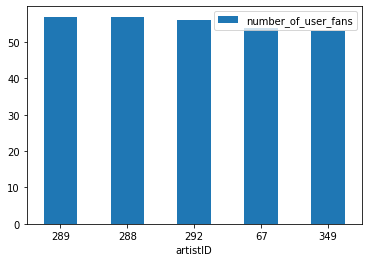

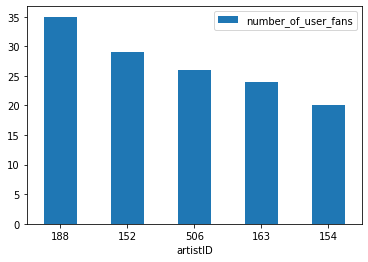

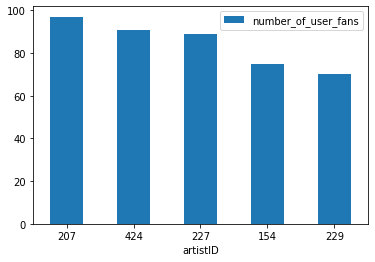

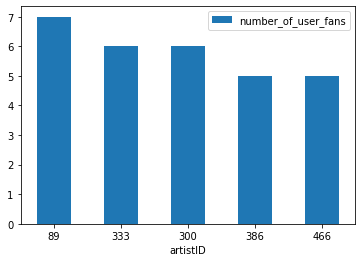

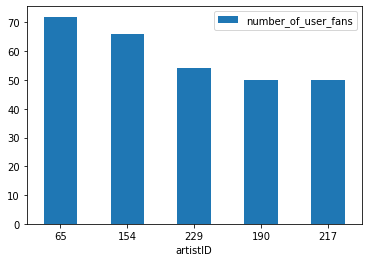

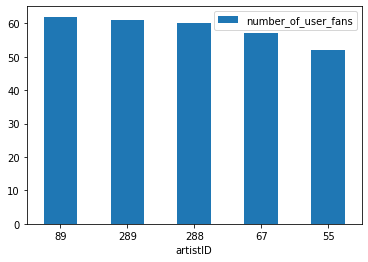

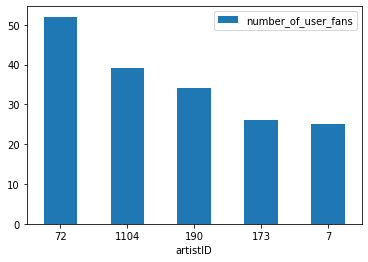

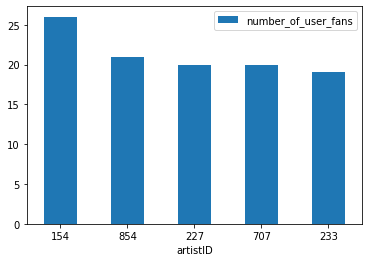

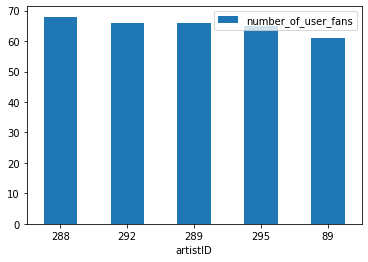

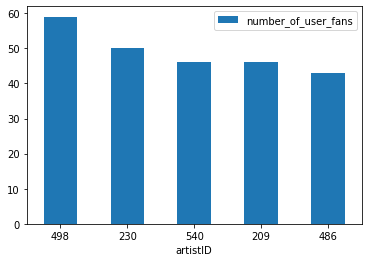

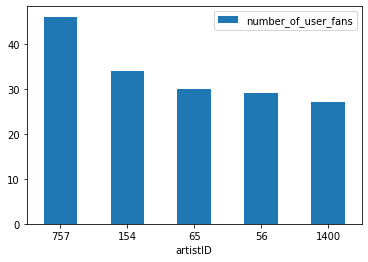

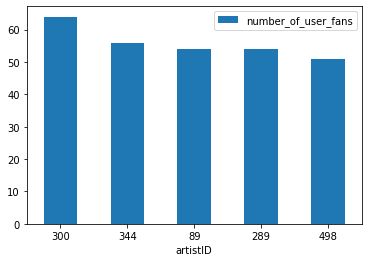

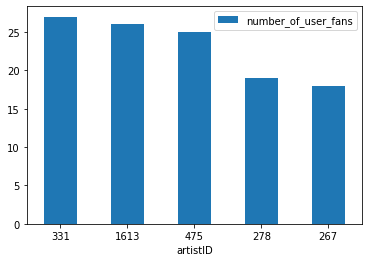

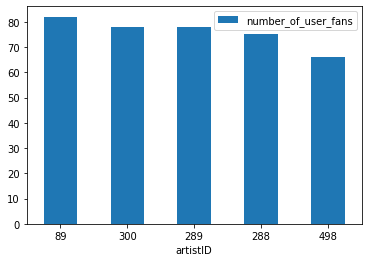

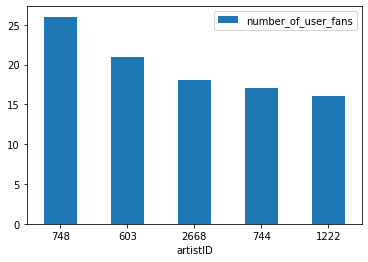

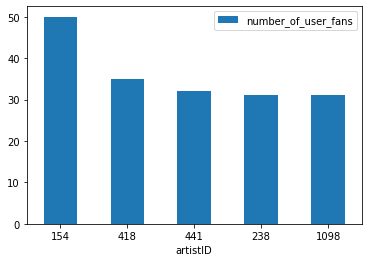

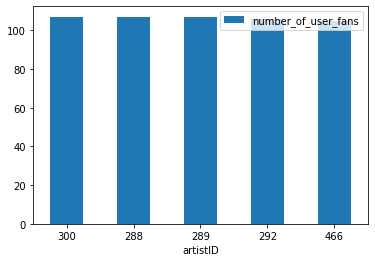

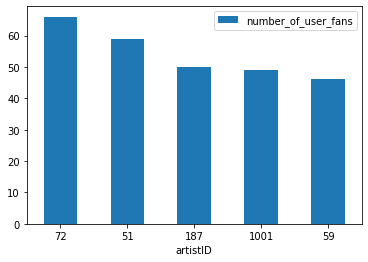

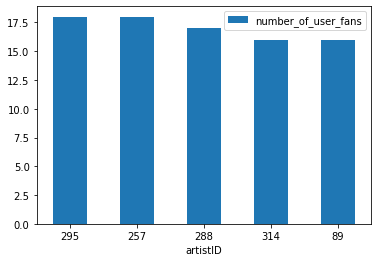

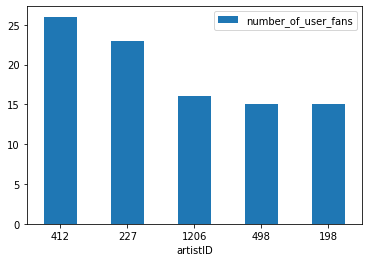

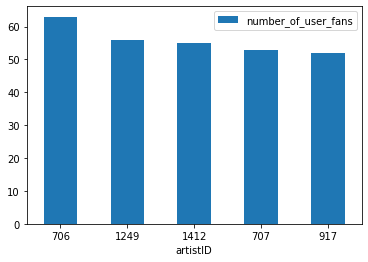

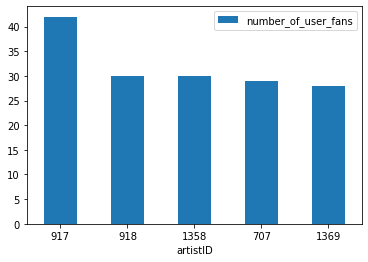

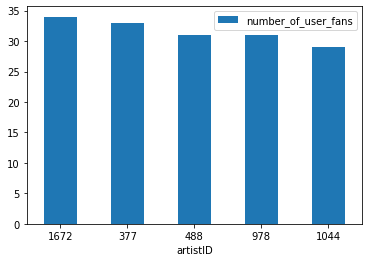

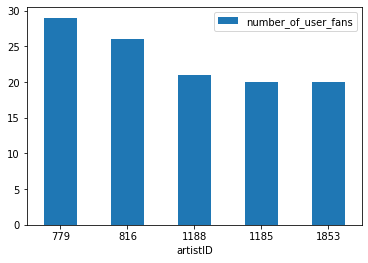

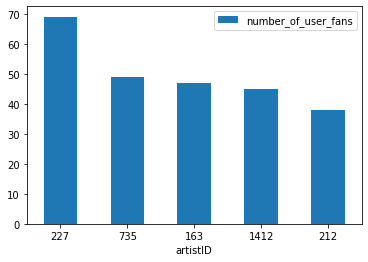

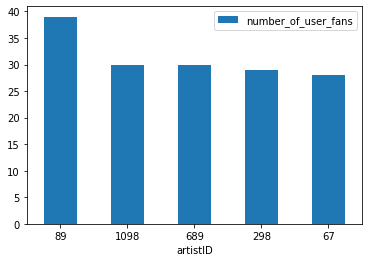

In [ ]:
for i in range(26):
  s=cluster_artists[i].sort_values(ascending=False, by=["Count"] )
  #print(s)
  df = pd.DataFrame({'artistID':s.iloc[:5]["artistID"], 'number_of_user_fans':s.iloc[:5]["Count"]})
  ax = df.plot.bar(x='artistID', y='number_of_user_fans', rot=0)

Prediction

In [ ]:
# prediction of the class for a given matrix 
x=matrix2[:150]
class_predict=kmeans.predict(x)
print(class_predict)
print(type(class_predict))
print(set(class_predict))

[17 19 17  4 18  0  8 19  4 13  3 16 19 15  3 13 24 14 16 22  7  5  0 21
 19 17 13 13 17 15  1 15 19 23  7 11 19  6 21  4 10  7 16 16 16  5  5  2
 21 19  5  0 12  2 13 16  6 19 15  4 20 19 22 17  0 14  2 21  0 17  3 16
 19  2 14  8 23 12 19 19 20  7 22  0  7  9 24 15  5 15 16 17 10  5 10  4
 23 24  4  9 14 19 21  1 20  8 15 19 21 20 19 12 17 22  1 11 13 24 10  6
 24 13 20  4  8  8 10 16 16 16  5  0 25 22  4 24 17 24 18 11 16  0 19  9
  8 19 11  1 22 19]
<class 'numpy.ndarray'>
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
#accuracy_score(clusters, class_predict)

In [ ]:
"""for i in range(13):
  cluster_artists=cluster_artists[cluster_artists["Count"] isin{1,2,3}]
  s=cluster_artists.sort_values(ascending=False, by=["Count"] )
  #print(s)
  df = pd.DataFrame({'artistID':s.iloc[:5]["artistID"], 'number_of_user_fans':s.iloc[:5]["Count"]})
  ax = df.plot.bar(x='artistID', y='number_of_user_fans', rot=0)"""

### **Evaluation**

First , we define the **train_test_split**  function to Split Data to Train/Test :

In [ ]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

Okay, that is a lot different than you might’ve expected. We remove some existing play counts from users by replacing them with zeros.

In [ ]:
train, val = train_test_split(ratings)

In [ ]:
train.shape

(1892, 17632)

####**Measuring the error**

One of the most popular metrics used to evaluate the accuracy of Recommender Systems is Root Mean Squared Error (RMSE)

Here is the RMSE function:

In [ ]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

####**Training**

In [ ]:
class Recommender:
  
  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
 # Finally, we are ready to make some recommendations for a user. Here is the implementation of the predict method:
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
    return y_hat[user_index, predictions_index].flatten()

In [ ]:
recommender = Recommender().fit(train, val)

####**Evaluation**


Let’s have a quick look at how the training process went by looking at the training and validation RMSE:

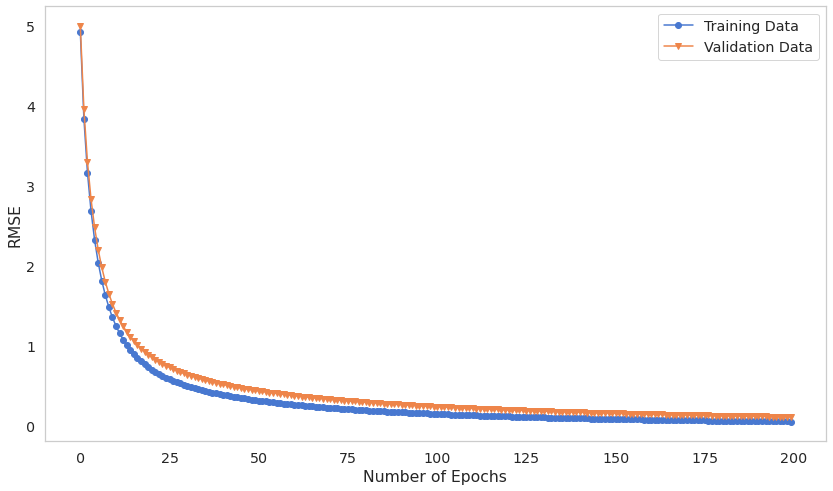

In [ ]:
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()